# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [118]:
# Load pickled data
import pickle
import os
# TODO: Fill this in based on where you saved the training and testing data

data_path = "./data"

training_file = data_path + "/train.p"
validation_file = data_path + "/test.p"
testing_file = data_path + "/valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [119]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import cv2
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt

# TODO: Number of training examples
n_train = len(x_train)

# TODO: Number of validation examples
n_validation = len(x_valid)

# TODO: Number of testing examples.
n_test = len(x_test)

# TODO: What's the shape of an traffic sign image?
image_shape= [x_train.shape[1], x_train.shape[2]]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number validation", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print(x_valid.shape)
print(12630/128)

Number of training examples = 34799
Number of testing examples = 4410
Number validation 12630
Image data shape = [32, 32]
Number of classes = 43
(12630, 32, 32, 3)
98.671875


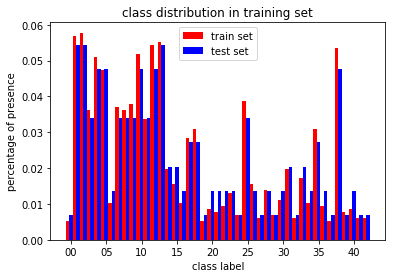

In [120]:
# Exploration of the dataset
# source: ndrplz github

train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('percentage of presence')
ax.set_xlabel('class label')
ax.set_title('class distribution in training set')
ax.set_xticks(np.arange(0, n_classes, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [121]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
GRAY_MODE = True


# def preprocess(rgbdata,n):
    
#     graydata = np.zeros(shape=[n,32,32,1])
#     #     # standardize features   graydata = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in graydata])
# #     graydata = np.float32(graydata)

# #     graydata -= np.mean(graydata, axis=0)
# #     print(graydata)
# #     graydata /= (np.std(graydata, axis=0) + np.finfo('float32').eps)
# #     print(graydata)

#     for i in range(n):
#         # need to have same shape as the network architecture
#         graydata[i]=np.reshape(cv2.cvtColor(rgbdata[i], cv2.COLOR_RGB2GRAY),(32,32,1))
        
# #     graydata = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in graydata])
# #     graydata = np.float32(graydata)

# #     graydata -= np.mean(graydata, axis=0)
# #     print(graydata)
# #     graydata /= (np.std(graydata, axis=0) + np.finfo('float32').eps)
# #     print(graydata)
# #     graydata -= 128
# #     print(graydata)
# #     graydata /= 128
# #     print(graydata)
#     return graydata


def preprocess(X,n):
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])
    X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X])
    X = np.float32(X)

    # standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    # provide option to train only grayscale model
    return(X)
    
if GRAY_MODE==True:
    x_train_norm = preprocess(x_train, n_train)
    x_test_norm = preprocess(x_test, n_test)
    x_valid_norm = preprocess(x_valid,n_validation)

n_channels = x_train_norm.shape[3]



In [122]:
print(x_train.shape)

(34799, 32, 32, 3)


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

### Include an exploratory visualization of the dataset

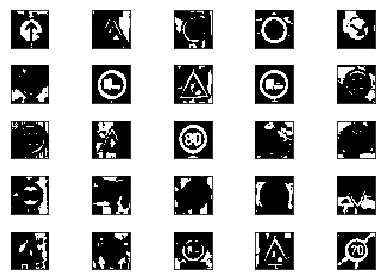

In [123]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
VISUALS = True
def visualize(data, n):
    c = 0
    for i in range(n*n):
#         print(data[i])
        image = data[i].astype(np.uint8)
        if GRAY_MODE:
            image = np.squeeze(image)
            plt.subplot(n,n,c+1)
            plt.imshow(image, cmap='gray')
            plt.plot()
            # remove redundant channel dimension

        else:
            plt.subplot(5,5,c+1)
            # assign 25 plots for 25 images
            plt.imshow(image)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
        c+=1
    plt.tight_layout()
    plt.show()
    
if VISUALS==True:
#     print(graydata)
    visualize(shuffle(x_train_norm),5)

In [ ]:
# augmentation: source: https://github.com/jeremy-shannon/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb
def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
       graydata = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in graydata])
#     graydata = np.float32(graydata)

#     graydata -= np.mean(graydata, axis=0)
#     print(graydata)
#     graydata /= (np.std(graydata, axis=0) + np.finfo('float32').eps)
#     print(graydata)
    return dst

def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst


def random_warp(img):
    
    rows,cols,_ = img.shape 

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

def augment(x_train, y_train):
    input_indices = []
    output_indices = []
    for class_n in range(n_classes):
        print(class_n, ': ', end='')
        class_indices = np.where(y_train == class_n)
        n_samples = len(class_indices[0])
        if n_samples < 800:
            for i in range(800 - n_samples):
                input_indices.append(class_indices[0][i%n_samples])
                output_indices.append(x_train.shape[0])
                new_img = x_train[class_indices[0][i % n_samples]]
                new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
                x_train = np.concatenate((x_train, [new_img]), axis=0)
                y_train = np.concatenate((y_train, [class_n]), axis=0)
    return(x_train,y_train)

x_train,y_train = augment(x_train,y_train)

### Model Architecture

In [124]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
#     inp1 = tf.nn.batch_normalization(x, mean = mu, variance = sigma)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, n_channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation.
    conv1 = tf.nn.elu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     drop1 = tf.nn.dropout(conv1, keep_prob=keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.elu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
#     drop2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.elu(fc1)
    fc1= tf.nn.dropout(fc1 , keep_prob=keep_prob)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    
    # Activation.

    fc2    = tf.nn.elu(fc2)
    fc2  = tf.nn.dropout(fc2, keep_prob=keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))

    logits = tf.matmul(fc2, fc3_W) + fc3_b


    return logits


In [125]:
print(len(x_train),len(y_train))

34799 34799


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [126]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

tf.reset_default_graph()

EPOCHS = 40
BATCH_SIZE = 64
rate = 0.001

graph1 = tf.Graph()
    
with graph1.as_default():
    x = tf.placeholder(tf.float32, (None, 32, 32, n_channels), name ='x')
    y = tf.placeholder(tf.int32, (None),'y')
    one_hot_y = tf.one_hot(y, n_classes, name ='onehoty')
    keep_prob = tf.placeholder(tf.float32)
    logits = LeNet(x)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits, name = 'xentropy')
    loss_operation = tf.reduce_mean(cross_entropy, name= 'loss')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate, name = 'optim')
    training_operation = optimizer.minimize(loss_operation, name = 'trainop')
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), name = 'correctpred')
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accpred')
    saver = tf.train.Saver()
    for i, var in enumerate(saver._var_list):
        print('Var {}: {}'.format(i, var))

def evaluate(x_data, y_data):
    num_examples = len(y_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:(offset+BATCH_SIZE)], y_data[offset:(offset+BATCH_SIZE)]
#         print(batch_x.shape,batch_y.shape)
#         print(offset)
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session(graph=graph1) as sess:
    # remember not executed until you hit sess.run
#     merged_summary = tf.summary.merge_all()
#     writer = tf.summary.FileWriter("graphs")
#     writer.add_graph(sess.graph)
    num_examples = len(x_train)
    sess.run(tf.global_variables_initializer())
    print("Training...")
    for i in range(EPOCHS):
        x_train_norm, y_train = shuffle(x_train_norm, y_train)
#         offset = (step * BATCH_SIZE) % (y_train.shape[0] - BATCH_SIZE)
        # Generate a minibatch.
#         batch_x = x_train[offset:(offset + BATCH_SIZE), :]
#         batch_y = y_train[offset:(offset + BATCH_SIZE), :]

        for offset in range(0, num_examples, BATCH_SIZE):
            
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train_norm[offset:end], y_train[offset:end]
#             summary = sess.run(merged_summary, feed_dict={x: batch_x, y: batch_y})
            training = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
#             writer.add_summary(summary,j)
        train_acc = evaluate(x_train_norm, y_train)
        validation_accuracy = evaluate(x_valid_norm, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {}".format(train_acc))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, 'tsc_8.ckpt')
    print("Model saved")
    
# visualization using tensorboard:

# with graph1.as_default():
#     x = tf.placeholder(tf.float32, (None, 32, 32, n_channels), name ='x')
#     y = tf.placeholder(tf.int32, (None),'y')
#     one_hot_y = tf.one_hot(y, n_classes, name ='onehoty')
#     logits = tf.py_func(func = LeNet, inp = [x], Tout= tf.float32,name = 'lenetmodel')
#     cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits, name='xentropy')
#     loss_operation = tf.reduce_mean(cross_entropy,name='lossop')
#     optimizer = tf.train.AdamOptimizer(learning_rate = rate, name='optimizer')
#     training_operation = optimizer.minimize(loss_operation)
#     saver = tf.train.Saver()
#     correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), name='correctpred')
#     accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accuracypred')
        

# create summaries for visualizing loss using tenso# with tf.name_scope("archiecture"):
#     logits = LeNet(x)
# loss function

# with tf.name_scope("cross_entropy"):
#     cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
#     #tf.summary.scalar("cross entropy", cross_entropy)
# with tf.name_scope("loss"):
#     loss_operation = tf.reduce_mean(cross_entropy)
# with tf.name_scope("train"):
#     optimizer = tf.train.AdamOptimizer(learning_rate = rate)
#     training_operation = optimizer.minimize(loss_operation)
# with tf.name_scope("accuracy"):
#     correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
#     accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# tf.summary.histogram("cross entropy",cross_entropy)
# tf.summary.scalar("reduce mean",loss_operation)
# tf.summary.scalar("acc",accuracy_operation)




Var 0: <tf.Variable 'Variable:0' shape=(5, 5, 1, 6) dtype=float32_ref>
Var 1: <tf.Variable 'Variable_1:0' shape=(6,) dtype=float32_ref>
Var 2: <tf.Variable 'Variable_2:0' shape=(5, 5, 6, 16) dtype=float32_ref>
Var 3: <tf.Variable 'Variable_3:0' shape=(16,) dtype=float32_ref>
Var 4: <tf.Variable 'Variable_4:0' shape=(400, 120) dtype=float32_ref>
Var 5: <tf.Variable 'Variable_5:0' shape=(120,) dtype=float32_ref>
Var 6: <tf.Variable 'Variable_6:0' shape=(120, 84) dtype=float32_ref>
Var 7: <tf.Variable 'Variable_7:0' shape=(84,) dtype=float32_ref>
Var 8: <tf.Variable 'Variable_8:0' shape=(84, 43) dtype=float32_ref>
Var 9: <tf.Variable 'Variable_9:0' shape=(43,) dtype=float32_ref>
Var 10: <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
Var 11: <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
Var 12: <tf.Variable 'Variable/optim:0' shape=(5, 5, 1, 6) dtype=float32_ref>
Var 13: <tf.Variable 'Variable/optim_1:0' shape=(5, 5, 1, 6) dtype=float32_ref>
Var 14: <tf.Variable 'Varia

## Validation Accuracy achieved: 0.927

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [110]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
from PIL import Image

def read_file(imgs, plotmode = False):
#     img = mpimg.imread(impath,0)
#     img = np.resize(img,[32,32,3])
    
    test_data = []
    
    for i in imgs:
        img = Image.open(i)
        img = img.resize([32,32])
        img = np.array(img)
        test_data.append(img)

    test_data = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in test_data])
#     test_data= np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in test_data])
#     test_data = np.float32(test_data)

#     test_data -= np.mean(test_data, axis=0)
#     test_data -= 128
#     test_data/=128
#     test_data /= (np.std(test_data, axis=0) + np.finfo('float32').eps)
    
#     test_data = preprocess(testdata, len(test_data))

    return test_data
    

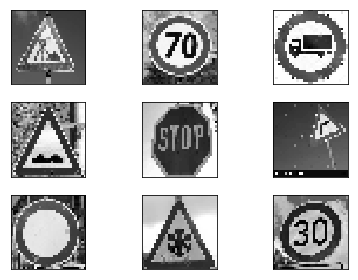

In [111]:
imdir = 'images/'
impaths = [imdir+'roadwork.jpg', imdir+'speedlimit70.jpg', imdir+'noover.jpg', imdir+'bumpy.png', imdir+'stop.jpg', imdir+'curv2right.jpg', imdir+'novehicles.png', imdir+ 'bewareice.png', imdir+ 'speed30.png']

testlabels = [25, 4, 10, 22, 14,20 ,15,30, 1]

# for i in impaths:
#     temp = read_file(i, True)
    
#     testset.append(temp)

testset = read_file(impaths)
visualize(testset, 3)
    

In [128]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.\

tf.reset_default_graph()

EPOCHS = 100
BATCH_SIZE = 128
rate = 0.001
# build new graph

x = tf.placeholder(tf.float32, (None, 32, 32, n_channels), name ='x')
y = tf.placeholder(tf.int32, (None),'y')
one_hot_y = tf.one_hot(y, n_classes, name ='onehoty')
keep_prob = tf.placeholder(tf.float32)
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits, name = 'xentropy')
loss_operation = tf.reduce_mean(cross_entropy, name= 'loss')
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name = 'optim')
training_operation = optimizer.minimize(loss_operation, name = 'trainop')
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1), name = 'correctpred')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accpred')

init_op = tf.global_variables_initializer()
loader = tf.train.Saver()

K = 5
with tf.Session() as sess:
#     loader= tf.train.import_meta_graph('lenet.ckpt.meta')
#     imported_graph = tf.get_default_graph()
#     print(imported_graph.get_all_collection_keys())
#     for i in imported_graph.get_collection('variables'):
#         print(i)
    loader.restore(sess, 'tsc_7.ckpt')
    predictions = []
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: testset, keep_prob:1.0})), axis=1)
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: testset, keep_prob:1.0})
    top_3 = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: testset, keep_prob:1.0})

    
print(prediction)
print(testlabels)
print(np.equal(prediction, testlabels))    
# print(softmax_probs[0][top_3[1][0][0]])
# print(top_3)


INFO:tensorflow:Restoring parameters from tsc_5.ckpt
[25  4 12 22 14 26 15 30  1]
[25, 4, 10, 22, 14, 20, 15, 30, 1]
[ True  True False  True  True False  True  True  True]


### Predict the Sign Type for Each Image

### Analyze Performance

In [115]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5signs correctly, it's 20% accurate on these new images.

print("Accuracy on test images: {}".format(np.sum(testlabels==prediction)/len(testlabels)))

Accuracy on test images: 0.7777777777777778


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [116]:
for i in range(len(testlabels)):
    print("Image: {}, Truth: {}".format(i, testlabels[i]))
    for j in range(K):
        top_confidence = top_3[1][i][j] # second tensor of topk output the indices
        print("Pred 1: {}, confidence: {}".format(top_confidence, softmax_probs[i][top_confidence]))
        

Image: 0, Truth: 25
Pred 1: 25, confidence: 0.9998564720153809
Pred 1: 4, confidence: 0.00014353101141750813
Pred 1: 27, confidence: 9.459156125046775e-09
Pred 1: 31, confidence: 2.932172950623202e-12
Pred 1: 5, confidence: 1.9407506746343698e-17
Image: 1, Truth: 4
Pred 1: 4, confidence: 1.0
Pred 1: 0, confidence: 0.0
Pred 1: 18, confidence: 0.0
Pred 1: 40, confidence: 0.0
Pred 1: 11, confidence: 0.0
Image: 2, Truth: 10
Pred 1: 12, confidence: 1.0
Pred 1: 16, confidence: 0.0
Pred 1: 40, confidence: 0.0
Pred 1: 9, confidence: 0.0
Pred 1: 41, confidence: 0.0
Image: 3, Truth: 22
Pred 1: 22, confidence: 1.0
Pred 1: 15, confidence: 0.0
Pred 1: 29, confidence: 0.0
Pred 1: 13, confidence: 0.0
Pred 1: 25, confidence: 0.0
Image: 4, Truth: 14
Pred 1: 14, confidence: 1.0
Pred 1: 1, confidence: 5.887566035625171e-37
Pred 1: 5, confidence: 0.0
Pred 1: 34, confidence: 0.0
Pred 1: 13, confidence: 0.0
Image: 5, Truth: 20
Pred 1: 26, confidence: 1.0
Pred 1: 39, confidence: 1.8043601721529513e-15
Pred 1

### Project Writeup

Please refer to writeup_final.md for the writeup